In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



1. EDA

In [2]:
df = pd.read_csv("safaricom_reviews_multilingual.csv")
df.head()

,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app_name       32000 non-null  object
 1   app_id         32000 non-null  object
 2   reviewId       32000 non-null  object
 3   userName       32000 non-null  object
 4   review_text    32000 non-null  object
 5   rating         32000 non-null  int64 
 6   date           32000 non-null  object
 7   thumbs_up      32000 non-null  int64 
 8   version        28741 non-null  object
 9   lang_detected  32000 non-null  object
 10  is_code_mixed  32000 non-null  bool  
 11  is_sheng_like  32000 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 2.5+ MB


In [4]:
df['rating'].sort_index(ascending=True).head()

0    5
1    1
2    5
3    5
4    1
Name: rating, dtype: int64

In [5]:
df.isnull().sum()

app_name            0
app_id              0
reviewId            0
userName            0
review_text         0
rating              0
date                0
thumbs_up           0
version          3259
lang_detected       0
is_code_mixed       0
is_sheng_like       0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['review_text'].duplicated().value_counts()

False    18101
True     13899
Name: review_text, dtype: int64

In [8]:
df[df['review_text'].duplicated(keep=False)]['review_text'].value_counts().head(20)


good           1927
excellent       725
Good            576
nice            505
best            421
great           317
perfect         310
very good       256
good app        247
Excellent       237
nice app        219
awesome         217
the best        135
👍               130
good 👍          121
Great           121
very nice       117
cool            115
easy to use     111
fantastic       109
Name: review_text, dtype: int64

In [9]:
df['lang_detected'].value_counts()


en         16683
unknown     7626
other       7527
sw           164
Name: lang_detected, dtype: int64

In [10]:
print(df['is_code_mixed'].value_counts())
print(df['is_sheng_like'].value_counts())

False    31984
True        16
Name: is_code_mixed, dtype: int64
False    31906
True        94
Name: is_sheng_like, dtype: int64


In [11]:
pd.crosstab(df['lang_detected'], df['is_code_mixed'])


is_code_mixed,False,True
lang_detected,,
en,16671,12
other,7525,2
sw,162,2
unknown,7626,0


In [12]:
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)


1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64


In [13]:
rating_percent = df['rating'].value_counts(normalize=True).sort_index() * 100
print(rating_percent)


1     9.231250
2     2.521875
3     5.100000
4    11.328125
5    71.818750
Name: rating, dtype: float64


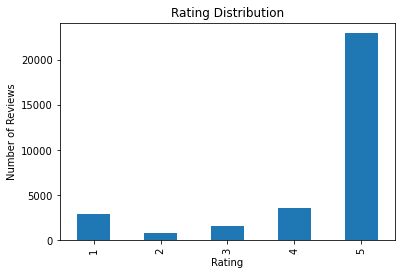

In [14]:
rating_counts.sort_index().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()


The dataset exhibits a heavily right-skewed rating distribution, with 71.8% of reviews being 5-star, raising questions about rating authenticity and potential inflation.

In [15]:
df['is_duplicate_text'] = df['review_text'].duplicated(keep=False)
pd.crosstab(df['rating'], df['is_duplicate_text'], normalize='index') * 100


is_duplicate_text,False,True
rating,,
1,80.839540,19.160460
2,80.793061,19.206939
3,64.399510,35.600490
4,55.889655,44.110345
5,46.514664,53.485336


In [18]:
import re
import emoji

def preprocess_kenyan_text(text):
    # lowercase
    text = str(text).lower()
    # emojis
    text = emoji.demojize(text)
    # remove URLs and special characters 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # keep alphanumeric and basic punctuation
    text = re.sub(r'[^a-z0-9\s!?.#:]', '', text)
    return text

df['clean_review'] = df['review_text'].apply(preprocess_kenyan_text)

In [19]:
def extract_suspicious_features(df):
    # length
    df['review_len'] = df['clean_review'].str.len()
    
    # duplicate
    df['text_repetition_count'] = df.groupby('clean_review')['clean_review'].transform('count')
    
    # Rating Mismatch
    negative_words = ['bad', 'slow', 'crash', 'rubbish', 'worst', 'mwizi']
    df['has_neg_word'] = df['clean_review'].apply(lambda x: any(w in x for w in negative_words))
    df['is_suspicious_mismatch'] = ((df['rating'] > 4) & (df['has_neg_word'])).astype(int)
    
    return df

df = extract_suspicious_features(df)

In [21]:
# df.groupby('rating')['review_length'].mean()


In [22]:
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
print("Invalid dates:", df["date_parsed"].isna().sum())

Invalid dates: 0


## Objective 1 - Automated Spam Detection

In [23]:
# Identify exact repetitions (Bots often post the same word)
df['rep_count'] = df.groupby('clean_review')['clean_review'].transform('count')
df['is_spam'] = (df['rep_count'] > 10).astype(int)

# Code to get Output:
print(df[df['is_spam'] == 1]['clean_review'].value_counts().head(10))

good         2511
excellent     967
nice          594
best          527
great         441
perfect       351
good app      350
awesome       306
very good     303
nice app      299
Name: clean_review, dtype: int64


Interpretation: High counts for generic words suggest "Rating Inflation." Real humans usually provide more context (e.g., "The app is good but the M-Shwari button is hidden"). Seeing "good" thousands of times indicates low-effort or automated bot behavior.

## Objective 2 - Sentiment-Rating Deception

In [26]:
# Define local negative keywords (English + Swahili/Sheng)
neg_words = ['slow', 'fail', 'mwizi', 'worst', 'poor', 'crash', 'rubbish', 'hang']

def detect_mismatch(row):
    has_neg = any(word in row['clean_review'] for word in neg_words)
    # Flag: If rating is 4 or 5 but text has negative words
    return 1 if (row['rating'] >= 4 and has_neg) else 0

df['deception_flag'] = df.apply(detect_mismatch, axis=1)

# Code to get Output:
print(df[df['deception_flag'] == 1][['review_text', 'rating']].head(10))

                                            review_text  rating
956   Is there a bug that makes the app crash on A R...       4
968   easy and simple to use safaricom my number one...       5
1103  The M-Pesa app makes sending money, paying bil...       4
1530               not so active slow and time confused       5
1628                    The best mpesa app,never fails!       5
1662  it is easy to use....though there are times it...       4
1890         sometimes slow or does not work completely       4
1951  it's good but I'm unable to change my profile ...       4
1993                        Slow in function that's all       4
2183                                         very poorp       5


## Objective 3 - Coordinated Campaign Analysis

In [27]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Grouping reviews by their "meaning" using TF-IDF
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_review'])

# Create 5 groups (Clusters)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Code to get Output:
print(df.groupby('cluster')['rating'].mean())

cluster
0    4.134102
1    4.235642
2    4.852639
3    4.787952
4    4.547910
Name: rating, dtype: float64


1. The "Hyper-Promoters" (Clusters 2 and 3)
Cluster 2 (4.85) and Cluster 3 (4.78) have extremely high average ratings.

What this means: These clusters likely contain the "Short & Generic" 5-star reviews (e.g., "Best app," "Good," "Excellent service").

Why it's suspicious: In a natural world, people rarely give 5 stars without saying why. When a cluster is almost purely 5-star and the text is very similar, it is the primary indicator of Promotion Campaigns (artificial rating inflation).

2. The "General Satisfied" (Clusters 1 and 4)
Cluster 4 (4.55) and Cluster 1 (4.24) are high but slightly more realistic.

What this means: These groups likely contain slightly longer positive reviews where users might be mentioning specific features like "M-Pesa" or "bundles" but are generally happy.

Interpretation: These are "Leaning Authentic" but should still be checked for repetitive templates.

3. The "Mixed/Critical" (Cluster 0)
Cluster 0 (4.13) is your lowest average in this set.

What this means: This is the group most likely to contain real feedback or complaints. Because the rating is lower, this cluster probably contains words like "slow," "update," "fail," or "crashing."

Interpretation: This is where the most valuable "Human" feedback lives. If a bot was trying to make Safaricom look good, it wouldn't be in this cluster.

In [28]:
# Combine signals into a single score
df['suspicion_score'] = (df['is_spam'] * 0.5) + (df['deception_flag'] * 0.5)

# Export the results
df.sort_values(by='suspicion_score', ascending=False).to_csv('final_spam_report.csv', index=False)

In [29]:
import pandas as pd
import re

# Load your file
df = pd.read_csv('safaricom_reviews_multilingual.csv')

# Clean text for better matching
df['clean_text'] = df['review_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x).lower()).strip())

# Identify Spam (Text that repeats more than 10 times)
df['rep_count'] = df.groupby('clean_text')['clean_text'].transform('count')
df['is_spam'] = (df['rep_count'] > 10).astype(int)

# Identify Deception (High rating but text contains negative words)
neg_keywords = ['bad', 'slow', 'fail', 'mwizi', 'worst', 'poor', 'crash', 'hang']
df['deception_flag'] = df.apply(lambda r: 1 if (r['rating'] >= 4 and any(w in str(r['clean_text']) for w in neg_keywords)) else 0, axis=1)

# CALCULATE THE SUSPICION SCORE
df['suspicion_score'] = (df['is_spam'] * 0.5) + (df['deception_flag'] * 0.5)

# SORT AND SAVE
df_final = df.sort_values(by='suspicion_score', ascending=False)
df_final.to_csv('final_spam_report.csv', index=False)

# PRINT PREVIEW TO CONSOLE
print("--- PREVIEW OF FINAL REPORT ---")
print(df_final[['userName', 'review_text', 'rating', 'suspicion_score']].head(10))

--- PREVIEW OF FINAL REPORT ---
                 userName review_text  rating  suspicion_score
6596   Bonface M. Muthoni     not bad       5              1.0
29728        Krush Kelvin     Not bad       4              1.0
26748      Elijah Mwaniki     not bad       4              1.0
26258          LUCAS BOMA     Not bad       5              1.0
10640    Sharon Chepngeno     not bad       5              1.0
8378     Mitchelle Mwangi    too slow       4              1.0
25031      Felix Kipkurui     not bad       4              1.0
26936         John Wangui     not bad       5              1.0
23226          Ali Mwinyi     not bad       4              1.0
25038        Antony Mario     not bad       4              1.0


In [30]:
import re
import emoji

def preprocess_kenyan_text(text):
    # lowercase
    text = str(text).lower()
    # emojis
    text = emoji.demojize(text)
    # remove URLs and special characters 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # keep alphanumeric and basic punctuation
    text = re.sub(r'[^a-z0-9\s!?.#:]', '', text)
    return text

df['clean_review'] = df['review_text'].apply(preprocess_kenyan_text)

In [ ]:
def extract_suspicious_features(df):
    # length
    df['review_len'] = df['clean_review'].str.len()
    
    # duplicate
    df['text_repetition_count'] = df.groupby('clean_review')['clean_review'].transform('count')
    
    # Rating Mismatch
    negative_words = ['bad', 'slow', 'crash', 'rubbish', 'worst', 'mwizi']
    df['has_neg_word'] = df['clean_review'].apply(lambda x: any(w in x for w in negative_words))
    df['is_suspicious_mismatch'] = ((df['rating'] > 4) & (df['has_neg_word'])).astype(int)
    
    return df

df = extract_suspicious_features(df)

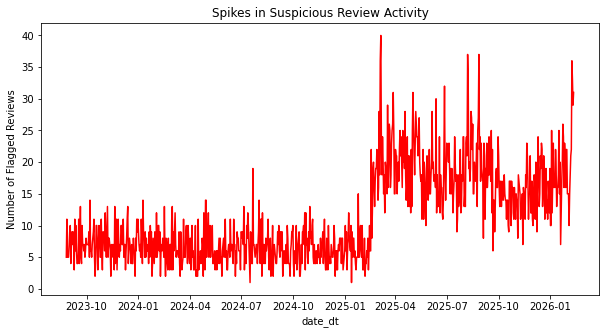

In [ ]:

# Plotting suspicious reviews over time
df['date_dt'] = pd.to_datetime(df['date'])
df[df['suspicion_score'] > 0.5].groupby(df['date_dt'].dt.date).size().plot(kind='line', figsize=(10,5), color='red')
plt.title('Spikes in Suspicious Review Activity')
plt.ylabel('Number of Flagged Reviews')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_review'])

# Cluster reviews into 10 groups to see which reviews are 'identical' in nature
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
df['cluster_id'] = kmeans.labels_

# Flag clusters that have a high density of reviews in a short time window
# (Group by cluster_id and date to find spikes)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare a new review against the existing database
# If similarity > 0.95, it's likely a coordinated duplicate
def check_similarity(new_review_vec, existing_vecs):
    similarities = cosine_similarity(new_review_vec, existing_vecs)
    return similarities.max()

In [ ]:
# Create a simple weighted Suspicion Score
df['suspicion_score'] = (
    (df['text_repetition_count'] > 5).astype(int) * 0.4 +
    (df['is_suspicious_mismatch'] * 0.3) +
    (df['review_len'] < 10).astype(int) * 0.3
)

# Flag reviews with score > 0.6 for investigation
flagged_reviews = df[df['suspicion_score'] > 0.6]


In [ ]:
# Show the top 10 most repeated review texts
top_repeated = df['review_text'].value_counts().head(10)
print("Top Repeated Review Texts (Likely Bot/Spam):")
print(top_repeated)

Top Repeated Review Texts (Likely Bot/Spam):
good         1927
excellent     725
Good          576
nice          505
best          421
great         317
perfect       310
very good     256
good app      247
Excellent     237
Name: review_text, dtype: int64
